In [1]:
%load_ext autoreload
%autoreload 2

import random

import matplotlib
import matplotlib.pyplot as plt
import torch

import mrnn
from mrnn import michaels_load
import mrnn.mrnn
from mrnn import lesion
from mrnn import observer
from mrnn import stim
from mrnn import utils

# Change to e.g. "cuda" to use GPU, if you have a CUDA device available.
# See https://pytorch.org/docs/stable/notes/cuda.html
# None means "use the CPU and main memory"
CUDA = None
NUM_NEURONS_PER_MODULE = 100

In [2]:
# This loads the actual mRNN network with model weights set
mike = mrnn.mrnn.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       cuda=CUDA)

/tmp/ipykernel_16744/90573749.py:7: RuntimeWarning: invalid value encountered in divide
  J_bin = J / J


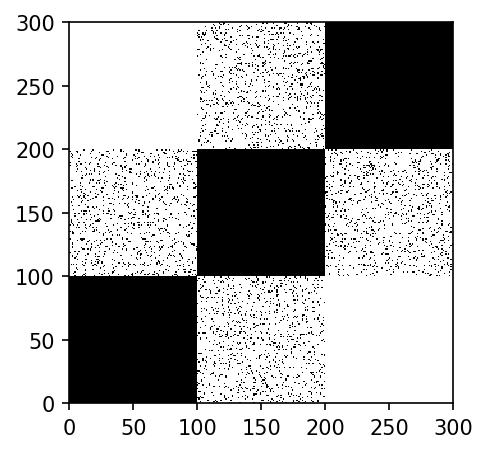

In [3]:
# Recall from the paper that the mRNN consists of 3 fully connected modules, and each module is sparsely connected
# to its neighbors. You can see that in the weight block matrix J.

plt.figure(figsize=(3.3, 3.3), dpi=150)
J = mike.J.cpu().detach().numpy()

J_bin = J / J

plt.pcolormesh(J_bin, cmap=matplotlib.cm.gray)
plt.show()

In [4]:
# Load data for one of the experiment sessions
# Dataset items are:
#   (michaels network input, trial end indicator, trial len (scalar),
#    target output, class label)
dataset = mrnn.mrnn.MichaelsDataset(mrnn.michaels_load.get_default_path(),
    cuda=CUDA, with_label=True)

# You can adjust the batch size here. It's not a large amount of data by today's
# standards, so we just have one giant batch with all data by default here.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

In [5]:
# In fact: let's go ahead and unroll the dataset for convenience of access
all_data = next(iter(dataloader))

# din: the visual feature inputs
din = all_data[0]
# dout: the muscle length velocity outputs
dout = all_data[-2]
# trial_end: indicates the end of the trial. This is needed
#   because not all trials are the same number of time steps.
trial_end = all_data[1]

# This truncates the douts to their trial ends.
# This zeros out all time steps beyond the end of the trial.
dout = utils.trunc_to_trial_end(dout, trial_end)

batch_size = din.shape[0]
trial_len = din.shape[1]
out_dim = dout.shape[-1]

# Batch idx, time, feature
print("Input shape:", din.shape)

# Batch idx, time, muscle idx
print("Output shape:", dout.shape)

Input shape: torch.Size([502, 341, 21])
Output shape: torch.Size([502, 341, 50])


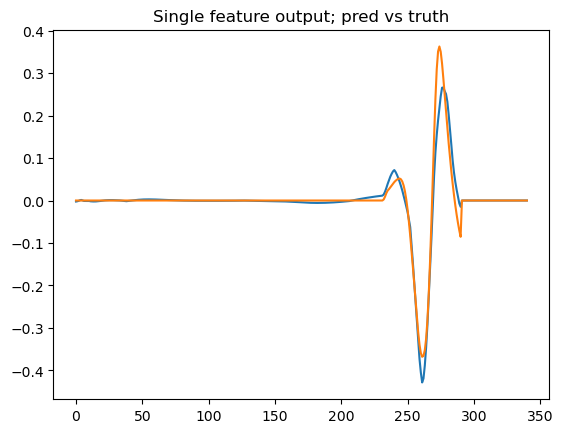

In [6]:
# Note the mRNN network reproduces the movements reasonably well

preds = torch.empty(batch_size, trial_len, out_dim).to(CUDA)
mike.reset()

for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    preds[:, tidx, :] = mike_out

preds = utils.trunc_to_trial_end(preds, trial_end)

bidx = random.randrange(batch_size)
fidx = random.randrange(out_dim)
plt.plot(preds[bidx,:,fidx].cpu().detach().numpy())
plt.plot(dout[bidx, :, fidx].cpu().detach().numpy())
plt.title("Single feature output; pred vs truth")
plt.show()

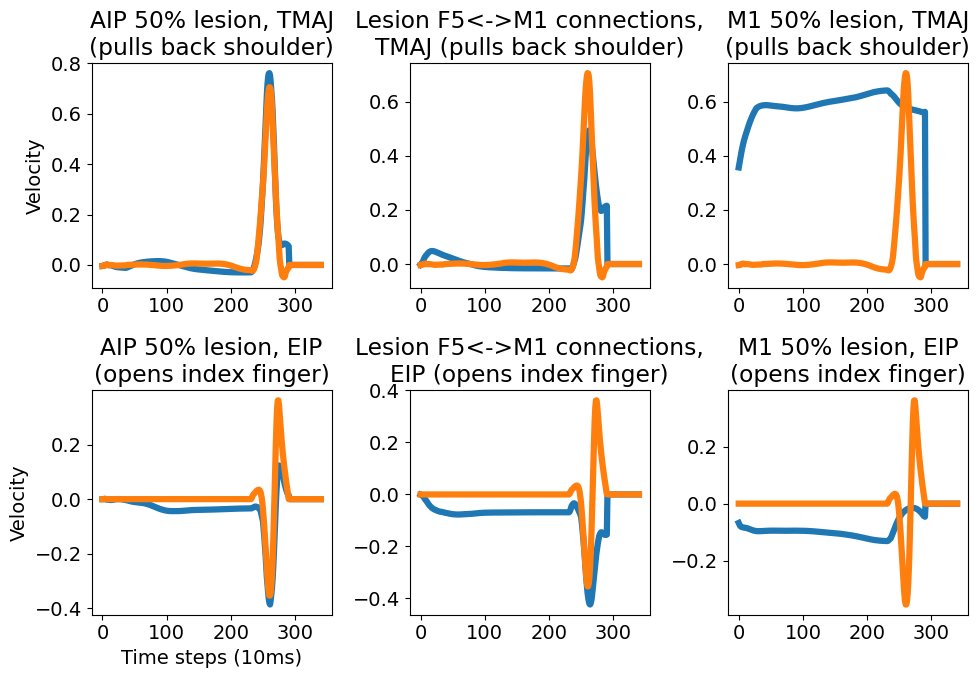

In [7]:
# Now lets see what happens when we apply some lesions to the network

plt.rc('font', size=14)


# Lesion half of the outputs of the AIP module
lesion_instance = lesion.LesionOutputs(NUM_NEURONS_PER_MODULE, 'AIP', 0.5, cuda=CUDA)
mike.set_lesion(lesion_instance)
mike.reset()

pred_out_lesion_aip = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    pred_out_lesion_aip = pred_out_lesion_aip.to(CUDA)
for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    pred_out_lesion_aip[:, tidx, :] = mike_out
pred_out_lesion_aip = utils.trunc_to_trial_end(pred_out_lesion_aip, trial_end)

# Lesion all connections F5 <-> M1
connections = [
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
]
mike.reset_hidden()
lesion_instance = lesion.LesionConnectionsByIdxs(NUM_NEURONS_PER_MODULE, connections, cuda=CUDA)
mike.set_lesion(lesion_instance)

pred_out_lesion_con = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    pred_out_lesion_con = pred_out_lesion_con.cuda(CUDA)
for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    pred_out_lesion_con[:, tidx, :] = mike_out
pred_out_lesion_con = utils.trunc_to_trial_end(pred_out_lesion_con, trial_end)

# Lesion the outputs of half of the M1 module
mike.reset_hidden()
lesion_instance = lesion.LesionOutputs(NUM_NEURONS_PER_MODULE, 'M1', 0.5, cuda=CUDA)
mike.set_lesion(lesion_instance)

pred_out_lesion_m1 = torch.empty(batch_size, trial_len, out_dim)
if CUDA:
    pred_out_lesion_m1 = pred_out_lesion_m1.cuda(CUDA)
for tidx in range(trial_len):
    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    pred_out_lesion_m1[:, tidx, :] = mike_out
pred_out_lesion_m1 = utils.trunc_to_trial_end(pred_out_lesion_m1, trial_end)


# Graph it
fig,axs = plt.subplots(2,3, figsize=(10, 7))
axs[0, 0].plot(pred_out_lesion_aip[bidx,:,7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 0].plot(preds[bidx, :, 7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 0].set_title("AIP 50% lesion, TMAJ\n(pulls back shoulder)")
axs[0, 0].set_ylabel("Velocity")
axs[1, 0].plot(pred_out_lesion_aip[bidx,:,45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 0].plot(dout[bidx, :, 45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 0].set_title("AIP 50% lesion, EIP\n(opens index finger)")
axs[1, 0].set_xlabel("Time steps (10ms)")
axs[1, 0].set_ylabel("Velocity")

axs[0, 1].plot(pred_out_lesion_con[bidx,:,7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 1].plot(preds[bidx, :, 7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 1].set_title("Lesion F5<->M1 connections,\nTMAJ (pulls back shoulder)")
axs[1, 1].plot(pred_out_lesion_con[bidx,:,45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 1].plot(dout[bidx, :, 45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 1].set_title("Lesion F5<->M1 connections,\nEIP (opens index finger)")

axs[0, 2].plot(pred_out_lesion_m1[bidx,:,7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 2].plot(preds[bidx, :, 7].cpu().detach().numpy(), linewidth=4.5)
axs[0, 2].set_title("M1 50% lesion, TMAJ\n(pulls back shoulder)")
axs[1, 2].plot(pred_out_lesion_m1[bidx,:,45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 2].plot(dout[bidx, :, 45].cpu().detach().numpy(), linewidth=4.5)
axs[1, 2].set_title("M1 50% lesion, EIP\n(opens index finger)")


mike.set_lesion(None)

fig.tight_layout()
plt.show()

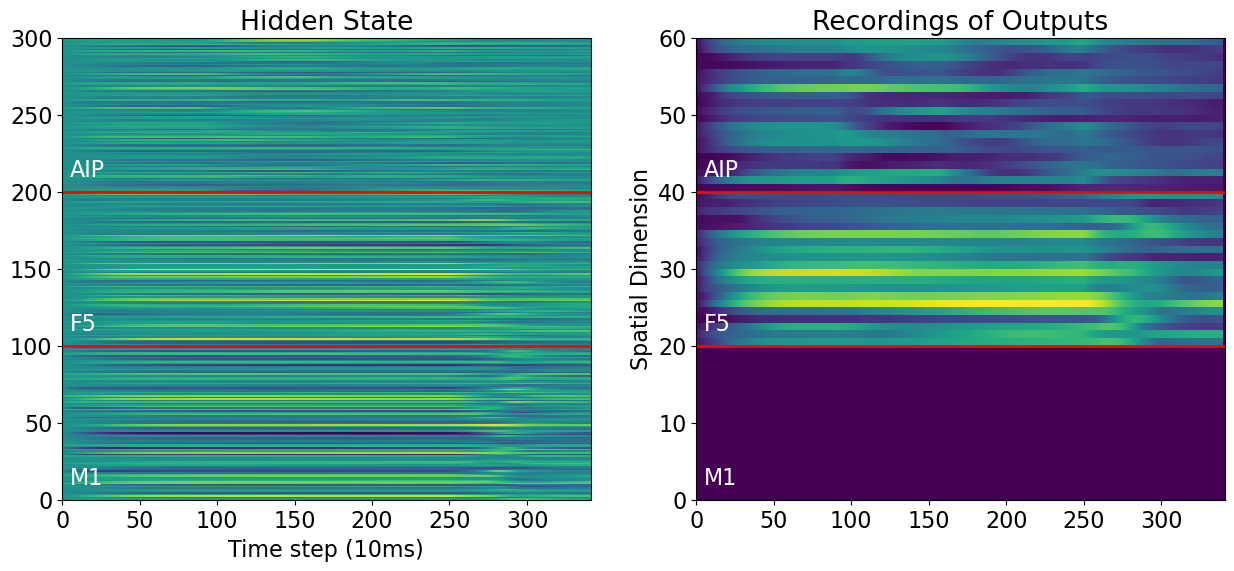

In [14]:
# Now let's take a look at the observation function. It is a partial observation of the network's
# outputs. There are many conceivable observation functions. See observer.py.
per_module_obs_dim = 20
example_observer = observer.ObserverType.gaussian.value(in_dim=NUM_NEURONS_PER_MODULE,
                                                        out_dim=per_module_obs_dim,
                                                        cuda=CUDA)

# As you'll see below, we will keep only observations from the AIP and F5 modules
obs = torch.zeros(batch_size, trial_len, 3 * per_module_obs_dim).to(CUDA)
hidden = torch.zeros(batch_size, trial_len, mike.num_neurons).to(CUDA)
preds = torch.empty(dout.shape).to(CUDA)
mike.reset()

mike_in = din[:, 0, :].T
mike_out = mike(mike_in)
preds[:, 0, :] = mike_out.detach()
hidden[:, 0, :] = mike.x

for tidx in range(1, trial_len):
    # Observe current activity. This assumes we can observer AIP and F5 but not M1 due to stimulation artifacts.
    #  i.e. drop_module_idx=0 means "drop M1 observations"
    obs_raw = mike.observe(example_observer, drop_module_idx=0)
    obs[:, tidx - 1, per_module_obs_dim:] = torch.cat(obs_raw, axis=1)

    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    hidden[:, tidx, :] = mike.x
    
    preds[:, tidx, :] = mike_out.detach()

bidx = random.randrange(batch_size)
plt.rc('font', size=16)
fig,axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].set_title("Hidden State")
axs[0].pcolormesh(hidden[bidx, :, :].cpu().detach().numpy().T)
axs[0].plot([0, trial_len], [mike.num_neurons_per_module, mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0].plot([0, trial_len], [2 * mike.num_neurons_per_module, 2 * mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0].text(5, 210, "AIP", color="w")
axs[0].text(5, 110, "F5", color="w")
axs[0].text(5, 10, "M1", color="w")
axs[0].set_xlabel("Time step (10ms)")

axs[1].set_title("Recordings of Outputs")
axs[1].pcolormesh(obs[bidx, :, :].cpu().detach().numpy().T)
axs[1].plot([0, trial_len], [per_module_obs_dim, per_module_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1].plot([0, trial_len], [2 * per_module_obs_dim, 2 * per_module_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1].text(5, 2 * per_module_obs_dim + 2, "AIP", color="w")
axs[1].text(5, per_module_obs_dim + 2, "F5", color="w")
axs[1].text(5, 2, "M1", color="w")
axs[1].set_ylabel("Spatial Dimension")
plt.show()

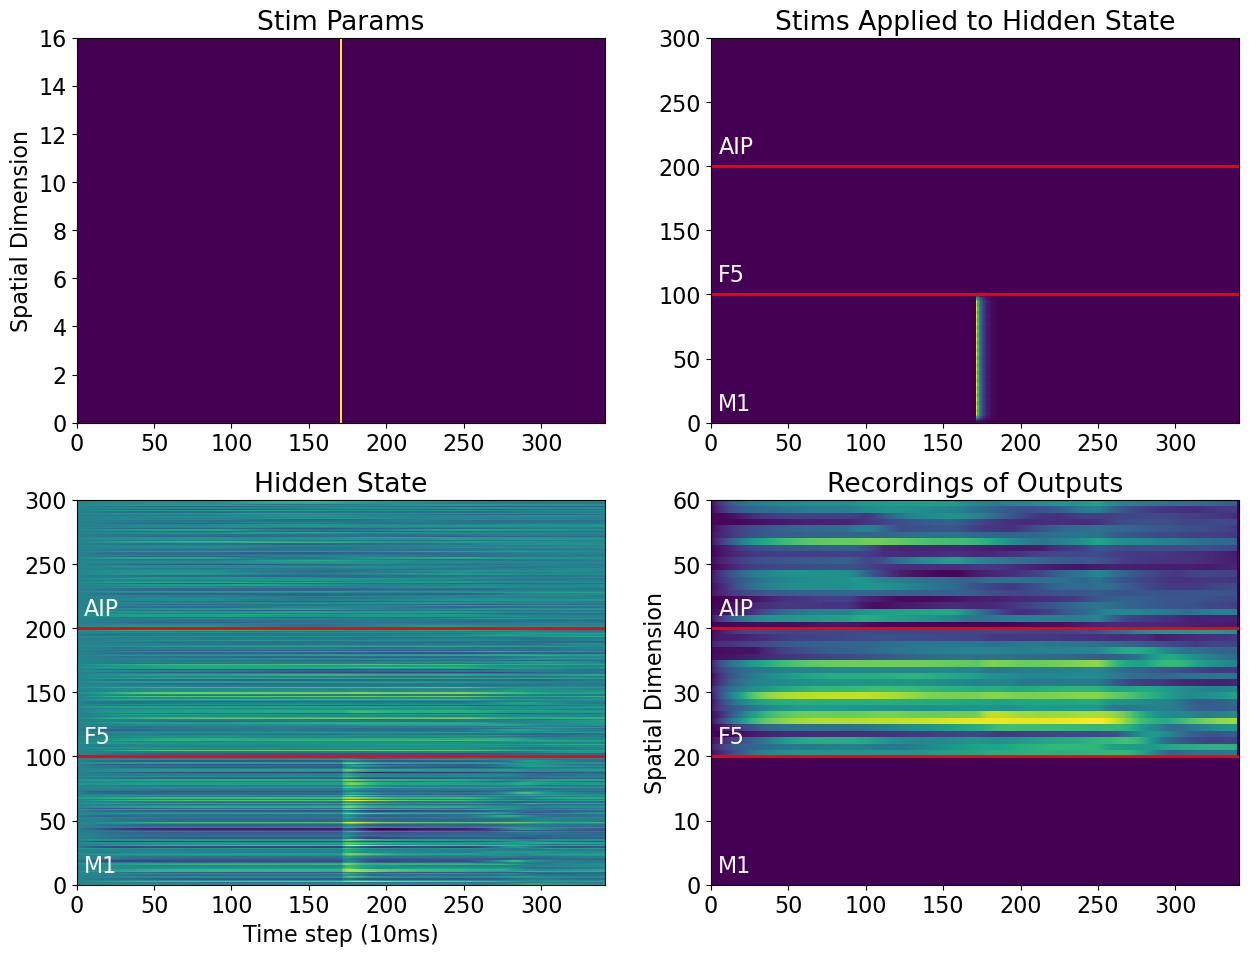

In [15]:
# Cool. Now let's do it again but mess with the outputs using a stimulation function.
# The default Gaussian implementation works like the observation function but in reverse: it "smears"
# the effect of stimulation both spatially and temporally, meaning that we can't do arbitrary things
# to the network.
# Let's apply one impulse of stimulation half way through the trials, just as an example.
tidx_half = round(tidx / 2)
stim_dim = 16


# We will be stimulating M1 only. We have 16 DoF spatially.
stimulus = stim.StimulationType.gaussian_exp.value(num_stim_channels=stim_dim,
                                                   num_neurons=NUM_NEURONS_PER_MODULE,
                                                   cuda=CUDA)
mike.stimulus = stimulus

stim_params = torch.zeros(batch_size, trial_len, stim_dim).to(CUDA)
stims = torch.zeros(batch_size, trial_len, mike.num_neurons).to(CUDA)
obs = torch.zeros(batch_size, trial_len, 3 * per_module_obs_dim).to(CUDA)
hidden = torch.zeros(batch_size, trial_len, mike.num_neurons).to(CUDA)
preds = torch.empty(dout.shape).to(CUDA)
mike.reset()

mike_in = din[:, 0, :].T
mike_out = mike(mike_in)
preds[:, 0, :] = mike_out.detach()
hidden[:, 0, :] = mike.x

batch_size = din.shape[0]

for tidx in range(1, trial_len):
    # Observe current activity. This assumes we can observer AIP and F5 but not M1 due to stimulation artifacts.
    #  i.e. drop_module_idx=0 means "drop M1 observations"
    obs_raw = mike.observe(example_observer, drop_module_idx=0)
    obs[:, tidx - 1, per_module_obs_dim:] = torch.cat(obs_raw, axis=1)

    mike_in = din[:, tidx, :].T
    mike_out = mike(mike_in)
    hidden[:, tidx, :] = mike.x
    
    stims[:, tidx, :] = mike.last_stimulus

    if tidx == tidx_half:
        next_stim_params = torch.ones(batch_size, stim_dim).to(CUDA) * 20.0

    else:
        next_stim_params = torch.zeros(batch_size, stim_dim).to(CUDA)

    stim_params[:, tidx, :] = next_stim_params
    
    mike.stimulate(next_stim_params)
    
    preds[:, tidx, :] = mike_out.detach()

plt.rc('font', size=16)
fig,axs = plt.subplots(2,2, figsize=(15, 11))
axs[0, 0].set_title("Stim Params")
axs[0, 0].pcolormesh(stim_params[bidx, :, :].cpu().detach().numpy().T)
axs[0, 0].set_ylabel("Spatial Dimension")

axs[0, 1].set_title("Stims Applied to Hidden State")
axs[0, 1].pcolormesh(stims[bidx, :, :].cpu().detach().numpy().T)
axs[0, 1].plot([0, trial_len], [mike.num_neurons_per_module, mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0, 1].plot([0, trial_len], [2 * mike.num_neurons_per_module, 2 * mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0, 1].text(5, 210, "AIP", color="w")
axs[0, 1].text(5, 110, "F5", color="w")
axs[0, 1].text(5, 10, "M1", color="w")

axs[1, 0].set_title("Hidden State")
axs[1, 0].pcolormesh(hidden[bidx, :, :].cpu().detach().numpy().T)
axs[1, 0].plot([0, trial_len], [mike.num_neurons_per_module, mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[1, 0].plot([0, trial_len], [2 * mike.num_neurons_per_module, 2 * mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[1, 0].text(5, 210, "AIP", color="w")
axs[1, 0].text(5, 110, "F5", color="w")
axs[1, 0].text(5, 10, "M1", color="w")
axs[1, 0].set_xlabel("Time step (10ms)")

axs[1, 1].set_title("Recordings of Outputs")
axs[1, 1].pcolormesh(obs[bidx, :, :].cpu().detach().numpy().T)
axs[1, 1].plot([0, trial_len], [per_module_obs_dim, per_module_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1, 1].plot([0, trial_len], [2 * per_module_obs_dim, 2 * per_module_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1, 1].text(5, 2 * per_module_obs_dim + 2, "AIP", color="w")
axs[1, 1].text(5, per_module_obs_dim + 2, "F5", color="w")
axs[1, 1].text(5, 2, "M1", color="w")
axs[1, 1].set_ylabel("Spatial Dimension")

plt.show()